In [1]:
#import important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import libraries for EDA and preprocessing
from datetime import datetime
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# import libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# import libraries for evaluating
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score,precision_score, f1_score
import time


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linhtran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/linhtran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 1: Gather data, determine the method of data collection and provenance of the data

Fake news is the deliberate spread of misinformation via traditional news media or via social media. False information spreads extraordinarily fast. This is demonstrated by the fact that, when one fake news site is taken down, another will promptly take its place. In addition, fake news can become indistinguishable from accurate reporting since it spreads so fast. People can download articles from sites, share the information, re-share from others and by the end of the day the false information has gone so far from its original site that it becomes indistinguishable from real news (Rubin, Chen, & Conroy, 2016). 

Thus, detecting false information or fake news can help people get the true stories, good information. In this project, I use data from Kaggle, were downloaded from the link:   https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset  

There are two data from this resource, included true and fake data. There are 23481 entries in fake and 21417 entries in true data. There are 4 columns in each data, included: title, text, subject and date. After reading these two data, I will create a new data by concatenating them together for training model later.


In [2]:
# read fake data
fake = pd.read_csv('Fake.csv')

# take a look at some rows of fake data
fake.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# read true data
true = pd.read_csv('True.csv')

# take a look at some rows of fake data
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# the shape of fake data
fake.shape


(23481, 4)

In [5]:
# the shape of true data
true.shape


(21417, 4)

In [6]:
# create label for concatenating data
fake["label"] = "fake"
true["label"] = "true"


In [7]:
# Concatenate fake and true news
df = pd.concat([fake, true]).reset_index(drop = True)

# take a look at some sample rows of new data
df.sample(10)

,title,text,subject,date,label
22467,Syria: US Peace Council Addresses United Natio...,Photo: Henry Lowendorf21st Century Wire says ...,US_News,"September 27, 2016",fake
3482,House Republicans Just Introduced Bill To Sla...,The Republican effort to let Social Security ...,News,"December 9, 2016",fake
38792,Cambodia marks independence from France with d...,PHNOM PENH (Reuters) - Cambodians on Thursday ...,worldnews,"November 9, 2017",true
40833,Czech ANO party dips but keeps commanding lead...,PRAGUE (Reuters) - Support for billionaire And...,worldnews,"October 16, 2017",true
3274,The Internet Loses It Over RNC’s Bizarre Stat...,The Republican National Committee released a b...,News,"December 25, 2016",fake
13979,HOUSE SPEAKER PAUL RYAN Puts The Party Before ...,HOUSE SPEAKER PAUL RYAN HAS SOUR GRAPES ABOUT ...,politics,"May 5, 2016",fake
15392,[VIDEO] HERO WHO EXPOSED PLANNED PARENTHOOD SA...,David Daleiden: We probably have hundreds to ...,politics,"Jul 30, 2015",fake
21609,HIGH SCHOOL TEACHER SEEKS HELP FROM UNION AFTE...,This is just another example of the rampant in...,left-news,"Jun 30, 2015",fake
19321,NICOLE KIDMAN BREAKS RANKS With Hollywood Left...,She s travelling the world to promote her new ...,left-news,"Jan 12, 2017",fake
27941,"Trump to speak with Germany's Merkel, Japan's ...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",true


## Step 2: Identify an Unsupervised Learning Problem

After concatenating fake and true data, the new data has two labels. And the goal is to assign one label to a news article in test data. The two labels we want to identify are fake and true.

To do this, we will train two kind of models:   
(1) two unsupervised models: included NMF using matrix factorization and clustering Kmeans.  
(2) multiple supervised models such as Random Forest, Logistic Regression and Decision Tree Classifier.     

These models are built to have their testing accuracy, RMSE score and confusion matrix, then I will compare these models for their performance.

## Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

### 3.1 Inspect the data

In [8]:
# get a quick description of the data
df.describe()


,title,text,subject,date,label
count,44898,44898,44898,44898,44898
unique,38729,38646,8,2397,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",fake
freq,14,627,11272,182,23481


In [9]:
# check null values in data
df.isnull().sum()


title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [10]:
# check for duplicate articles
df.duplicated(keep=False).sum()


405

In [11]:
# remove duplicates articles
df = df.drop_duplicates(keep=False)

# check shape of new data
df.shape

(44493, 5)

In [12]:
# the structure of data also tells us the number of rows (observations) and columns (variables)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44493 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44493 non-null  object
 1   text     44493 non-null  object
 2   subject  44493 non-null  object
 3   date     44493 non-null  object
 4   label    44493 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [13]:
# convert date column from object to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# view some first rows of the data
df.head()


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake


In [14]:
# get the label of data
df['label'].unique()


array(['fake', 'true'], dtype=object)

In [15]:
# get the label of data
df['subject'].unique()


array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east', 'politicsNews', 'worldnews'], dtype=object)

From the output above, after concatenating fake and true news data, we can summarize that:  
+ There are 44898 entries and 5 columns in new data. 
+ There is no missing values.
+ There are 405 duplicated articles.  
+ After removing duplicated rows, our data has 44493 entries and 5 columns. 
+ All columns are object. Therefore, date column was converted to date time.
+ There are 2 labels: fake and true.
+ There are 8 subjects: 'News', 'politics', 'Government News', 'left-news', 'US_News', 'Middle-east', 'politicsNews' and 'worldnews'.
  

### 3.2 Visualize the data

Next, I will do some works for visualizing the data:  
+ calculate and visualize the count and the proportion of each label.
+ calculate and visualize the count and the proportion of each subject.
+ explore the label by year.
+ explore the label by month.


In [16]:
# calculate the count of each label
df['label'].value_counts()


fake    23475
true    21018
Name: label, dtype: int64

In [17]:
# calculate the proportion of each label
df['label'].value_counts()/len(df)*100


fake    52.761108
true    47.238892
Name: label, dtype: float64

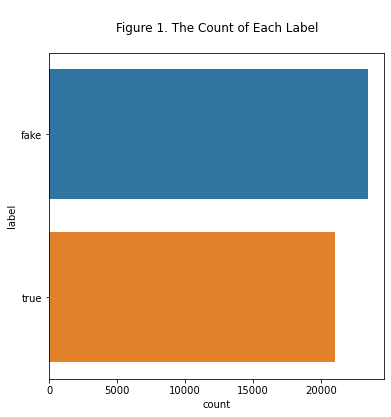

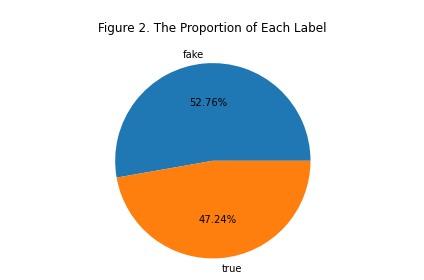

In [18]:
# plot the count of each label
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=df, y='label', ax=ax).set(title='\nFigure 1. The Count of Each Label\n')

# plot the proportion of each category
labels = df['label'].unique().tolist()
counts = df['label'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 2. The Proportion of Each Label\n")
plt.tight_layout()
plt.show()


Figure 1 shows the count of each label and figure 2 shows the proportions of each label. Looking at these two figures, we can see that in overall, the number of article for each category is not different too much. I think this is good since if one or two categories was severely underrepresentated or, in contrast, overrepresentative in the train data, then it may cause our model to be biased and/or perform poorly on some or all of the test data.

In [19]:
# calculate the count of each subject
subjects = df['subject'].value_counts()
subjects

politicsNews       11181
worldnews           9837
News                9050
politics            6835
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [20]:
# calculate the proportion of each subject
proportions = subjects/len(df)*100
print(proportions)

politicsNews       25.129796
worldnews          22.109096
News               20.340278
politics           15.361967
left-news          10.021801
Government News     3.528645
US_News             1.759827
Middle-east         1.748590
Name: subject, dtype: float64


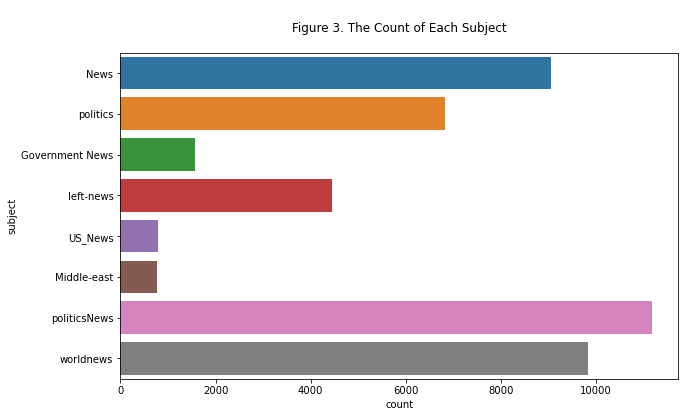

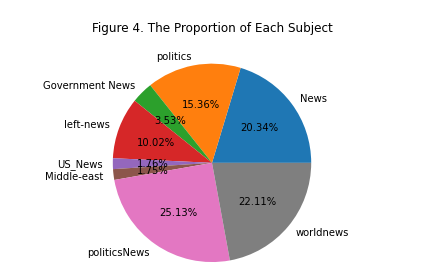

In [21]:
# plot the count of each subject
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=df, y='subject', ax=ax).set(title='\nFigure 3. The Count of Each Subject\n')

# plot the proportion of each category
sub_labels = df['subject'].unique().tolist()
counts = df['subject'].value_counts()
sizes = [counts[v] for v in sub_labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=sub_labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 4. The Proportion of Each Subject\n")

plt.tight_layout()
plt.show()

Figure 3 shows the count of each subject, figure 4 shows the proportion of each subject. There are 8 subjects in the data, included News, Polictics, Government News, Left-news, US_News, Middle-east, Polictic News and World News. Among these subjects, the number of Polictic News articles is the most (25.13%), next are World News (22.11%) and News (20.34%). The least number of articles belongs to US News (1.76%) and Middle-east (1.75%).

In [22]:
# extract month and year from date column
df["year"] = pd.DatetimeIndex(df['date']).year
df["month"] = pd.DatetimeIndex(df['date']).month
df.head()


,title,text,subject,date,label,year,month
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,2017.0,12.0


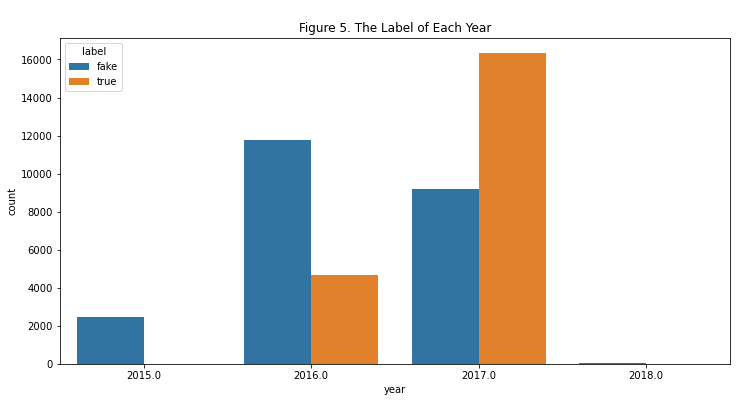

In [23]:
# explore each label by year
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="year", data=df, hue="label", ax=ax).set(title='\nFigure 5. The Label of Each Year')
plt.show()


Figure 5 shows that in 2015, there is no true news, but fake news and misinformation had become prevalent during 2016. However, on the contrary, the number of true news was much more than the number of fake news in 2017. We do not have much data in 2018.

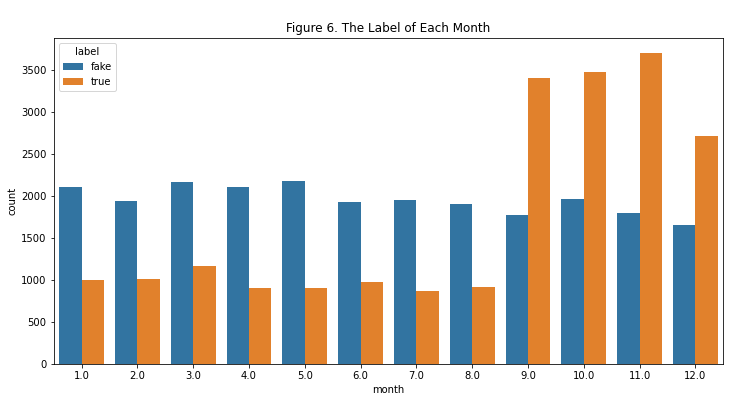

In [24]:
# explore each label by month
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="month", data=df, hue="label", ax=ax).set(title='\nFigure 6. The Label of Each Month')
plt.show()


Looking at figure 6, we can see that in overall, the number of fake news is larger than the number of true news from January to August and then on the contrary, the number of true news is larger than the number of fake news from September to December.

### 3.3 Clean the data

To prepare the data for training models, some works have to be done such as:  
+ create new feature by combining title and text column.
+ drop unused columns such as: date, year, month, title.   

To preprocess our text simply means to bring our text into a form that is predictable and analyzable for our task. So, what I am going to do is:   

(1) lowercasing all our text data    
(2) remove punctuation    
(3) remove stop words: stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. The intuition behind using stop words is that, by removing low information words from text, we can focus on the important words instead.  
(4) lemmatization: lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words.
    
Since I'm planning to redo these cleaning steps for a test data without label as well, thus for convenience, I will create a clean_text function for this data and reuse it for cleaning unlabeled test data later.

In [25]:
# create new feature by combining the title and text column
df['text'] = df['title'] + ' ' + df['text']

# drop date, year, month, title columns and reorder the columns
df_news = df.drop(columns=["date", "year", "month", "title"])
df_news = df_news.loc[:,['text','subject','label']]

# view some sample rows of df_news
df_news.sample(10)

,text,subject,label
9637,BOOM! WATCH VIDEO FOUND Proving Gen. Kelly Rig...,politics,fake
38724,War crimes court backs Burundi investigation A...,worldnews,true
7667,SNL Perfectly SLAMS Trump Supporters With ‘Ra...,News,fake
29380,Syrian Christians denied entry to U.S. in Phil...,politicsNews,true
42018,Two-thirds of Germans see persistent east-west...,worldnews,true
11763,BOOM! Companies That Openly Criticized Trump F...,politics,fake
43041,Kyrgyzstan accuses Kazakhstan of backing oppos...,worldnews,true
19717,ANTI-HILLARY HALLOWEEN HOUSE Gets Violent Thre...,left-news,fake
14610,GERMANY CRISIS ESCALATES: Muslim Migrants Mast...,politics,fake
4863,Comedy Central’s Roast Of Rob Lowe HIJACKED A...,News,fake


In [26]:
def clean_text(data, text):
    # lowercasing all text data
    data[text] = data[text].str.lower()
    # remove punctuation
    data[text] = data[text].str.replace('[^\w\s]', '', regex=True)
    # remove stop words
    stop_words = stopwords.words('english')
    data[text] = data[text].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    data[text] = data[text].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return


In [27]:
# clean news data
clean_text(df_news, "text")

# view text in the first row after cleaning all text data
df_news["text"][0]


'donald trump sends embarrassing new year eve message disturbing donald trump wish american happy new year leave instead give shout enemy hater dishonest fake news medium former reality show star one job country rapidly grows stronger smarter want wish friend supporter enemy hater even dishonest fake news medium happy healthy new year president angry pant tweeted 2018 great year america country rapidly grows stronger smarter want wish friend supporter enemy hater even dishonest fake news medium happy healthy new year 2018 great year america donald j trump realdonaldtrump december 31 2017trump tweet went welll expectwhat kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizen happy new year bishop talbert swan talbertswan december 31 2017no one like calvin calvinstowell december 31 2017your impeachment would make 2018 great year america also accept regaining control congress miranda yave

In [28]:
# calculate the count of word per article
df_news["Word_Count"] = df_news['text'].apply(lambda x: len(x.split()))


In [29]:
# view some first rows of news data
df_news.head()


,text,subject,label,Word_Count
0,donald trump sends embarrassing new year eve m...,News,fake,296
1,drunk bragging trump staffer started russian c...,News,fake,187
2,sheriff david clarke becomes internet joke thr...,News,fake,349
3,trump obsessed even obamas name coded website ...,News,fake,273
4,pope francis called donald trump christmas spe...,News,fake,218


In [30]:
# The average count of word per article
print("\nThe mean count of word per article is ", round(np.mean(df_news.Word_Count)))

# The maximum count of word per article
print("\nThe maximum count of word per article is ", round(np.max(df_news.Word_Count)))

# The minimum count of word per article
print("\nThe minimum count of word per article is ", round(np.min(df_news.Word_Count)))



The mean count of word per article is  242

The maximum count of word per article is  4933

The minimum count of word per article is  2


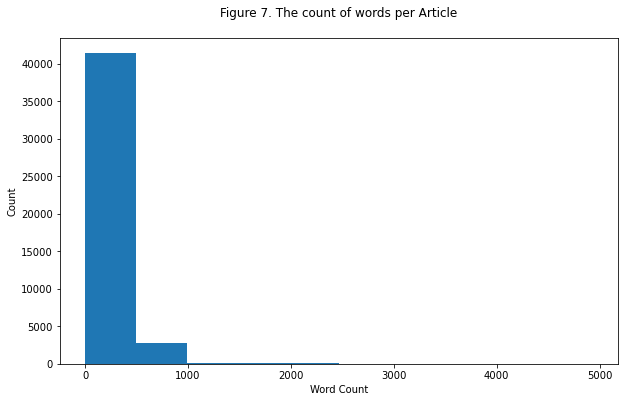

In [31]:
# plot the count of word per article
fig, ax = plt.subplots(figsize=(10,6))
df_news['Word_Count'].plot(kind='hist')
plt.xlabel("Word Count")
plt.xticks(rotation=360)
plt.ylabel("Count")
plt.title("Figure 7. The count of words per Article\n")
plt.show()


We see that the average count of words per article is about 252 and looking at Figure 7, there are some outliers that have over 1000 word count per article. Thus, I would like to remove articles that have more than 1000 words. And then I will plot the count of words per subject.

In [32]:
# remove outliers have more than 1000 words
df_news = df_news[df_news.Word_Count <= 1000]
len(df_news)


44189

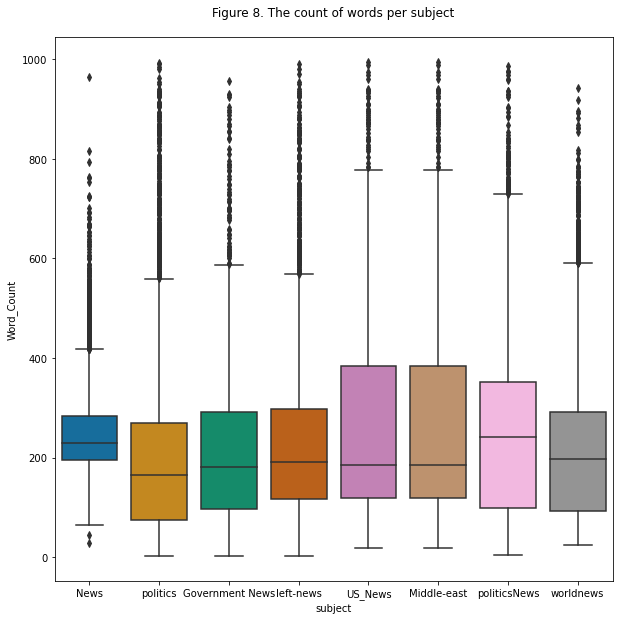

In [33]:
# visualize the count of words per subject
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data = df_news, x = 'subject', y = 'Word_Count', palette = 'colorblind'
           ).set(title = 'Figure 8. The count of words per subject\n')
plt.show()


Looking at Figure 8, we observe that the mean of word count of each subject is not different much, News and politics News have more words than other subjects. There is a greater variability for US News and Middle-east compare with others.

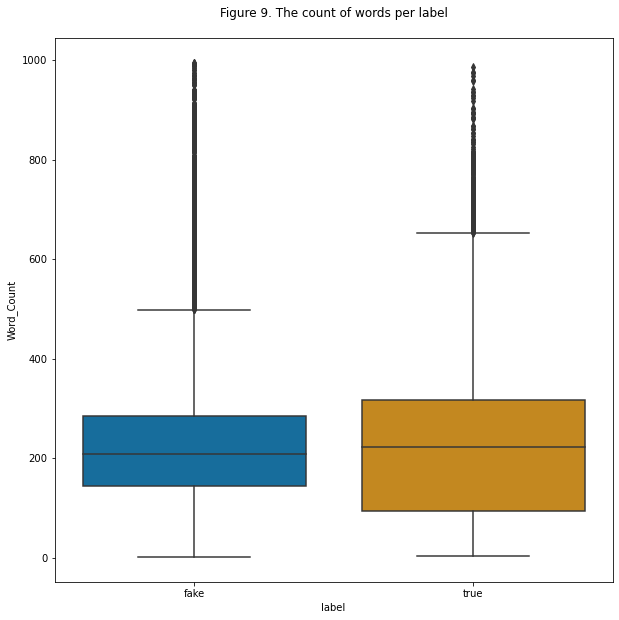

In [34]:
# visualize the count of words per label
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data = df_news, x = 'label', y = 'Word_Count', palette = 'colorblind'
           ).set(title = 'Figure 9. The count of words per label\n')
plt.show()


Looking at figure 9, we observe that the mean of word count of fake and true news is approximately the same, the variability for true news is a little bit greater than fake news.

#### Split data

After cleaning, to prepare for building and training models, I'll:
+ first, drop word_count column.   
+ split 20% of the data into test set. Noted that, I'll use sklearn train_test_split to split the data, with default shuffle = True, means this method will split our data into random train and test subsets.  


In [35]:
# drop word_count column 
df_news = df_news.drop(columns='Word_Count')

# shuffle and split the data into train and test set
train, test = train_test_split(df_news, test_size=0.2, random_state = 42)

# view some first rows of train data
print('Training set:')
train. head()


Training set:


,text,subject,label
41208,mattis say u work stay aligned turkey despite ...,worldnews,true
26913,trump dismay anger ally abandoning global clim...,politicsNews,true
16381,obama made christian pastor pay ticket home ir...,Government News,fake
35960,bulgaria freeze asset independent medium publi...,worldnews,true
41134,zimbabwe ruling party plan vote strengthen mug...,worldnews,true


In [36]:
# get shape of train dataset after splitting
train.shape

(35351, 3)

In [37]:
# view some first rows of test data
print('Test set:')
test.head()


Test set:


,text,subject,label
6430,happening trump say rudy giuliani head commiss...,News,fake
33613,u top court hand win union split 44 without sc...,politicsNews,true
34502,trump cruz tamp expectation uncertain iowa vot...,politicsNews,true
9772,college conservative stalked antifa campus sto...,politics,fake
20824,latina restaurant owner threatened called stag...,left-news,fake


In [38]:
# get shape of test set after splitting
test.shape


(8838, 3)

## Step 4: Building and training models

### 4.1 Vectorizing Text by TfidfVectorizer

Text data requires a special approach to machine learning. This is because text data can have hundreds of thousands of dimensions (words and phrases) but tends to be very sparse. For example, the English language has around 100,000 words in common use. But in this data, average word count of an article only contains about 240 words. 

Machines, unlike humans, cannot understand the raw text. Machines can only see numbers. Particularly, statistical techniques such as machine learning can only deal with numbers. Therefore, we need to convert our text into numbers (vectors) so as the algorithms will be able make predictions.

Different approaches exist to convert text into the corresponding numerical form. In this case I will use the Term Frequency — Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents. Note that we are passing a number of parameters to this work:
    
+ min_df is used for removing terms that appear too infrequently, set to 2 means "ignore word that appear in less than 2 articles". This is to avoid rare words, which drastically increase the size of our features and might cause overfitting.      
+ max_df is used for removing terms that appear too frequently, set to 0.95 means "ignore terms that appear in more than 95% of the documents".    
+ norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1. This is helpful for visualizing these vectors, and can also improve (or deteriorate) the performance of some models.   
+ ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams, or in other terms: we want to consider single words ("prices", "player") and pairs of words ("stock prices", "football player").   
+ stop_words is set to "english" to remove all common pronouns ("a", "the", ...) and further reduce the number of noisy features.   
+ sublinear_df is set to True to use a logarithmic form for frequency, to give diminishing returns as the frequency of a word increases.   


In [39]:
# use TFIDF to convert words into numerical features
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, norm='l2', ngram_range=(1, 2), stop_words='english', sublinear_tf=True)

# fit and transform on train data
X = vectorizer.fit_transform(train.text)

In [40]:
# Get a feel of the features identified by tfidf
X.toarray()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
# get the shape of the features
X.shape


(35351, 1124227)

### 4.2 Unsupervised Machine Learning for Natural Language Processing and Text Analytics

Unsupervised machine learning involves training a model without pre-tagging or annotating. 


#### 4.2.1 NMF

Matrix Factorization is another technique for unsupervised NLP machine learning. This uses “latent factors” to break a large matrix down into the combination of two smaller matrices. Latent factors are similarities between the items.

In this project, I would like to build a Non-Negative Matrix Factorization (NMF) model.  I will pass n_components=2 into the model because we have 2 labels, with other parameters, in order to find best ones for this model, I will: 
+ create predict function: this function predict label of an article based on the largest value of each row in features matrix.
+ create label_permute_compare function: this function will return permuted label order, accuracy and RMSE score.  

Then, I will apply these two functions into the next step that programmatically evaluate which init, solver and beta_loss metric lead to the best performance.  


In [42]:
# create predict function
def predict(W_matrix):
    sortedW = np.argsort(W_matrix)
    n_prediction, maxValue = sortedW.shape
    prediction = [[sortedW[i][maxValue - 1]] for i in range(n_prediction)]
    topic = np.empty(n_prediction, dtype = np.int64)
    for i in range(n_prediction):
        topic[i] = prediction[i][0]
    return topic


In [43]:
# create label permuation compare
def label_permute_compare(ytdf, yp, n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    p = list(itertools.permutations(list(range(n))))
    label_ls = list(ytdf['label'].unique())
    acc_score = []
    rmse_score = []
    #recall_score = []
    #pre_score = []
    #f1_score = []
    for i in range(len(p)):
        map_dict = dict(zip(label_ls, list(p[i])))
        yt = ytdf['label'].apply(lambda x:map_dict[x])
        acc_score.append(accuracy_score(yt, yp))
        #recall_score.append(recall_score(yt, yp))
        #pre_score.append(precision_score(yt, yp))
        #f1_score.append(f1_score(yt, yp))
        rmse_score.append(np.sqrt(mean_squared_error(yt, yp)))
    index = np.argmax(acc_score)
    #return p[index], acc_score[index], recall_score[index], pre_score[index], f1_score[index]
    return p[index], acc_score[index], rmse_score[index]


In [46]:
# programmatically evaluate which init, solver and beta_loss metric lead to the best performance

#dic = {"time":0, "init":"", "solver": "", "beta_loss":"", "labelorder":[], "acc":0, "recall":0, "precision":0, "f1":0}
dic = {"time":0, "init":"", "solver": "", "beta_loss":"", "labelorder":[], "acc":0, "rmse":0}
df_nmf = pd.DataFrame(dic)
for init in ["random", "nndsvda", "nndsvdar", "custom"]:
    for beta_loss in ["frobenius", "kullback-leibler", "itakura-saito"]:
        for solver in ["cd", "mu"]:
            acc = 0
            t0 = time.time()
            try:
                model = NMF(n_components=2, init=init, solver = solver, beta_loss=beta_loss, random_state = 42)
                yhat_train = predict(model.fit_transform(X))
                label_order, acc, rmse = label_permute_compare(train, yhat_train)
                t1 = time.time()
                df_nmf.loc[len(df_nmf.index)] = [t1-t0, init, solver, beta_loss, label_order, acc, rmse]
              
            except:
                print(init, "with", beta_loss, "with", solver, "not allowed.")
df_nmf = df_nmf.sort_values(by='acc', ascending = False)
display(df_nmf)


random with kullback-leibler with cd not allowed.
random with itakura-saito with cd not allowed.
random with itakura-saito with mu not allowed.
nndsvda with kullback-leibler with cd not allowed.
nndsvda with itakura-saito with cd not allowed.
nndsvda with itakura-saito with mu not allowed.
nndsvdar with kullback-leibler with cd not allowed.
nndsvdar with itakura-saito with cd not allowed.
nndsvdar with itakura-saito with mu not allowed.
custom with frobenius with cd not allowed.
custom with frobenius with mu not allowed.
custom with kullback-leibler with cd not allowed.
custom with kullback-leibler with mu not allowed.
custom with itakura-saito with cd not allowed.
custom with itakura-saito with mu not allowed.


,time,init,solver,beta_loss,labelorder,acc,rmse
3,32.389216,nndsvda,cd,frobenius,"(1, 0)",0.819864,0.424425
6,28.144366,nndsvdar,cd,frobenius,"(1, 0)",0.819864,0.424425
1,9.588517,random,mu,frobenius,"(0, 1)",0.814065,0.431202
8,126.670549,nndsvdar,mu,kullback-leibler,"(1, 0)",0.806455,0.439937
5,104.159139,nndsvda,mu,kullback-leibler,"(1, 0)",0.804843,0.441766
4,13.074447,nndsvda,mu,frobenius,"(1, 0)",0.744477,0.505493
7,12.844088,nndsvdar,mu,frobenius,"(1, 0)",0.740149,0.509756
2,274.391801,random,mu,kullback-leibler,"(0, 1)",0.679189,0.566402
0,6.443513,random,cd,frobenius,"(1, 0)",0.514865,0.696516


In [47]:
# show the best model
best_nmf_model = NMF(n_components=2, init="nndsvda", solver = "cd", beta_loss="frobenius", random_state = 42)

# fit and transform the model to TF-IDF:
W = best_nmf_model.fit_transform(X)
H = best_nmf_model.components_


In [48]:
# features dimension
W.shape

(35351, 2)

In [49]:
# components dimension
H.shape

(2, 1124227)

In [50]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(H, columns=vectorizer.get_feature_names())
components_df


,00,000,000 child,000 hospital,000 today,000 year,0000,0000 gmt,0005,0005 kilogram,...,zych said,zygote,zynga,zynga medium,zypries,zypries said,zyuganov,zzzzaaaacccchhh,žižek,žižek american
0,0.000351,0.000861,0.000122,0.000087,0.000087,0.000087,0.000069,0.000069,0.000000,0.000000,...,0.000140,0.000221,0.000302,0.000071,0.000000,0.00000,0.000046,0.000353,0.000265,0.000265
1,0.000102,0.000000,0.000000,0.000015,0.000015,0.000015,0.000177,0.000177,0.000294,0.000294,...,0.000008,0.000000,0.000219,0.000092,0.001349,0.00089,0.000236,0.000000,0.000000,0.000000


We have created the 2 labels using NMF. Let’s have a look at the 10 more important words for each label.


In [51]:
# get 10 more important words for each label
mapdict_df = dict(zip(label_order, list(train["label"].unique())))
for label in range(components_df.shape[0]):
    tmp = components_df.iloc[label]    
    print(f'For label {mapdict_df[label]}, the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')
    

For label fake, the words with the highest value are:
trump           0.928233
republican      0.570412
clinton         0.456049
donald          0.445448
donald trump    0.426279
people          0.413081
president       0.402421
image           0.383837
like            0.382337
said            0.381882
Name: 0, dtype: float64


For label true, the words with the highest value are:
said            0.590084
reuters         0.456924
state           0.418777
united          0.359840
minister        0.355655
government      0.354960
north           0.317334
korea           0.314728
official        0.306373
united state    0.301514
Name: 1, dtype: float64




#### Use best NMF model to predict test data

In [57]:
# use best model for predicting test set and calculate accuracy
X_test = vectorizer.fit_transform(test.text)
W_test = best_nmf_model.fit_transform(X_test)

# predict label for test data
yhat_test = predict(W_test)
#label_order_test, accuracy_test, recall_test, pre_test, f1_test = label_permute_compare(test, yhat_test)
label_order_test, accuracy_test, rmse_test = label_permute_compare(test, yhat_test)
mapdict_test = dict(zip(list(test["label"].unique()), label_order_test))
print('\nLabel order for test set based on best NMF model: ', mapdict_test)
print('\nAccuracy for test set based on best NMF model: {:.3f}%'.format(accuracy_test*100))
print('\nRMSE for test set based on best NMF model: {:.3f}'.format(rmse_test))
#print('\nRecall score for test set based on best NMF model: {:.3f}%'.format(recall_test*100))
#print('\nPrecision score for test set based on best NMF model: {:.3f}%'.format(pre_test*100))
#print('\nF1 score for test set based on best NMF model: {:.3f}%'.format(f1_test*100))



Label order for test set based on best NMF model:  {'fake': 0, 'true': 1}

Accuracy for test set based on best NMF model: 83.661%

RMSE for test set based on best NMF model: 0.404



Figure 10. Best NMF - Confusion matrix for test set: 


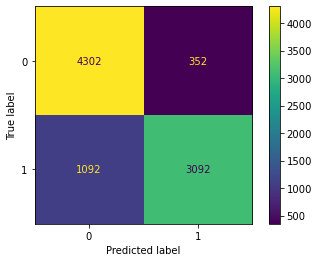

In [53]:
# Check confusion matrix
yt_test = test["label"].apply(lambda x: mapdict_test[x])
print('\nFigure 10. Best NMF - Confusion matrix for test set: ')
cm = confusion_matrix(yt_test, yhat_test)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

From Figure 10, the confusion matrix for test set based on best NMF model, we can summarize that:  

+ Our model predicted that 5394/8838 articles are fake news when there were actually 4654/8838 articles with fake news.  

+ Our model has an accuracy of 7394/8838 or 83.661%


#### 4.2.2 Kmeans

Clustering means grouping similar documents together into groups or sets. These clusters are then sorted based on importance and relevancy (hierarchical clustering). 

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms. The K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. The ‘means’ in the K-means refers to averaging of the data, finding the centroid.  



In [54]:
# build kmeans model
kmeans = KMeans(n_clusters=2, init = 'k-means++' , max_iter = 100, random_state=0).fit(X)

# fit and transform kmeans model to TF-IDF:
W_kmeans = kmeans.fit_transform(X)


In [55]:
# use kmeans model for predicting test set and calculate accuracy
X_test = vectorizer.fit_transform(test.text)
W_test_kmeans = kmeans.fit_transform(X_test)

# predict label for test data
yhat_test_kmeans = predict(W_test_kmeans)
label_order_test_kmeans, accuracy_test_kmeans, rmse_test_kmeans = label_permute_compare(test, yhat_test_kmeans)
mapdict_test_kmeans = dict(zip(list(test["label"].unique()), label_order_test_kmeans))
print('\nLabel order for test set based on Kmeans model: ', mapdict_test_kmeans)
print('\nAccuracy for test set based on Kmeans model: {:.3f}%'.format(accuracy_test_kmeans*100))
print('\nRMSE for test set based on best Kmeans model: {:.3f}'.format(rmse_test_kmeans))



Label order for test set based on Kmeans model:  {'fake': 0, 'true': 1}

Accuracy for test set based on Kmeans model: 91.333%

RMSE for test set based on best Kmeans model: 0.294



Figure 11. Kmeans - Confusion matrix for test set: 


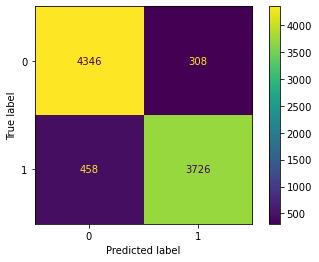

In [56]:
# Check confusion matrix
yt_test_kmeans = test["label"].apply(lambda x: mapdict_test_kmeans[x])
print('\nFigure 11. Kmeans - Confusion matrix for test set: ')
cm_kmeans = confusion_matrix(yt_test_kmeans, yhat_test_kmeans)

# display confusion matrix
disp_kmeans = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans)
disp_kmeans.plot()
plt.show()


From Figure 11, the confusion matrix for test set based on Kmeans model, we can summarize that:  

+ Our model predicted that 4804/8838 articles are fake news when there were actually 4654/8838 articles with fake news.  

+ Our model has an accuracy of 8072/8838 or 91.333%


####  4.2.3 Compare unsupervised learning models

In [58]:
# create unsupervised dataframe to compare NMF and Kmeans model on test data
unsuper_models = {'Model': ["NMF", "Kmeans"],
        'Accuracy': [accuracy_test, accuracy_test_kmeans],
        'RMSE': [rmse_test, rmse_test_kmeans]}
unsuper_data = pd.DataFrame(unsuper_models)
unsuper_data = unsuper_data.sort_values(by='Accuracy', ascending = False, ignore_index=True)
print("Compare unsupervised machine learning models on test data: ")
display(unsuper_data)


Compare unsupervised machine learning models on test data: 


,Model,Accuracy,RMSE
0,Kmeans,0.913329,0.29440
1,NMF,0.836615,0.40421


With the result above, we observe that Kmeans has better performance with higher Accuracy and lower RMSE.

### 4.3 Supervised Machine Learning for Natural Language Processing and Text Analytics

In supervised machine learning, a batch of text documents are tagged or annotated with examples of what the machine should look for and how it should interpret that aspect. These documents are used to “train” a statistical model, which is then given un-tagged text to analyze.

In this project, since our train data has the labels, we can use supervised models to solve the label of each news article. That is, we look for a classifier that can take a word embedding as an input and predict a text class. To keep things simple, we will use the same preprocessing and word embedding produced by TfidfVectorizer with the same hyperparameters.

I would like to choose building a Random Forest model, because it can perform classification tasks and produces good predictions that can be understood easily. Moreover, it can handle large datasets efficiently. The random forest algorithm provides a higher level of accuracy in predicting outcomes over the decision tree algorithm. To build Random Forest, I will do hyperparameter tuning for Random Forest using GridSearchCV to find the best one. Then fit the data and use it for predicting test data.

Next, I would like to use some supervised NLP machine learning algorithms such as:  
    + Logistic Regression  
    + Decision Tree  
    
I choose to build Logistic Regression because it is a calculation used to predict a binary outcome: either something happens, or does not. And in this case, since we want to predict a news is fake news or not, thus Logistic Regression is suitable for this project.   

Besides that, a decision tree is also good for this project because it is a supervised learning algorithm that is perfect for classification problems, as it’s able to order classes on a precise level. It works like a flow chart, separating data points into two similar categories at a time from the “tree trunk” to “branches,” to “leaves,” where the categories become more finitely similar. This creates categories within categories, allowing for organic classification with limited human supervision.
    
To do this work, first, I will a Random Forest model by using GridSearchCV to find the best one with best parameters and best score. Then I will use it to predict for test data, calculate accuracy score and confusion matrix as well. Since I prepare for building other supervised models as well, so I will create a pipeline function, it helps to enforce desired order of application steps, creating a convenient work-flow, which makes sure of the reproducibility of the work.

After finding the best Random Forest model, I will use pipeline above to train Logistic Regression and Decision Tree to predict for test data, calculate accuracy, recall, precision, f1 score and confusion matrix.


#### 4.3.1 Random Forest

In [59]:
# Let’s do hyperparameter tuning for Random Forest using GridSearchCV and fit the data.
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [5,10,20],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [30,50,100,200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X, train.label)


Fitting 4 folds for each of 48 candidates, totalling 192 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [60]:
# get the best score
rf_best_score = grid_search.best_score_
print("\nRandom Forest best score: {:.3f}%".format(rf_best_score*100))

# best model
rf_best = grid_search.best_estimator_
print("\nRandom Forest best model:", rf_best)


Random Forest best score: 96.716%

Random Forest best model: RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)


After getting the best Random Forest model, now I will use it to predict test data. 
 

In [61]:
# set up the model pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
def pipeline_func(vectorizer, clf):
    pipeline = Pipeline(
        [
            ('vect', vectorizer),
            ('clf', clf)
        ]
    )

    # fit and predict for test set
    pipeline.fit(train.text, train.label)
    y_pred = pipeline.predict(test.text)

    # calculate accuracy
    accuracy_test = accuracy_score(test.label, y_pred)
    #rmse_test = np.sqrt(mean_squared_error(test.label, y_pred))
    recall_test = recall_score(test.label, y_pred, pos_label="true")
    pre_test = precision_score(test.label, y_pred, pos_label="true")
    f1_test = f1_score(test.label, y_pred, pos_label="true")
    cm = confusion_matrix(test.label, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return accuracy_test, recall_test, pre_test, f1_test, disp

Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values

In [67]:
# fit model and predict test data
rf_acc, rf_recall, rf_pre, rf_f1, rf_disp = pipeline_func(vectorizer, rf_best)



Accuracy for test set based on best Random Forest model: 0.955

Recall score for test set based on best Random Forest model: 0.923

Precision score for test set based on best Random Forest model: 0.981

F1 score for test set based on best Random Forest model: 0.923

Figure 12. Random Forest - Confusion matrix for test set


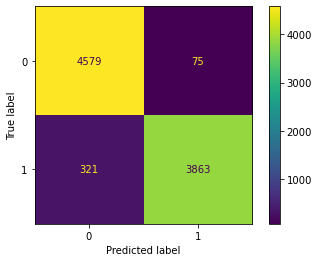

In [68]:
print('\nAccuracy for test set based on best Random Forest model: {:.3f}'.format(rf_acc))
print('\nRecall score for test set based on best Random Forest model: {:.3f}'.format(rf_recall))
print('\nPrecision score for test set based on best Random Forest model: {:.3f}'.format(rf_pre))
print('\nF1 score for test set based on best Random Forest model: {:.3f}'.format(rf_recall))
print('\nFigure 12. Random Forest - Confusion matrix for test set')
rf_disp.plot()
plt.show()

From the confusion matrix for test set based on best Random Forest model, we can summarize that:  

+ Our model predicted that 4900/8838 articles are fake news when there were actually 4654/8838 articles with fake news.  

+ Our model has an accuracy of 8442/8838 or 95.519%


#### 4.3.2 Other supervised machine learning

After finding the best Random Forest model, now I would like to run some other models such as: Logistic Regression and Decision Tree as well.  


##### Logistic Regression

In [63]:
# fit model and predict test data
log_acc, log_recall, log_pre, log_f1, log_disp = pipeline_func(vectorizer, LogisticRegression())
 


Accuracy for test set based on Logistic Regression model: 0.989

Recall score for test set based on Logistic Regression model: 0.992

Precision score for test set based on Logistic Regression model: 0.984

F1 score for test set based on Logistic Regression model: 0.988

Figure 13. Logistic Regression - Confusion matrix for test set


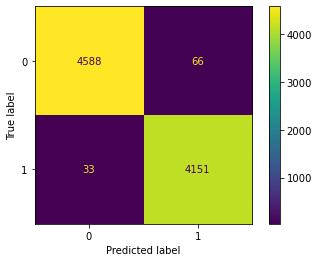

In [70]:
print('\nAccuracy for test set based on Logistic Regression model: {:.3f}'.format(log_acc))
print('\nRecall score for test set based on Logistic Regression model: {:.3f}'.format(log_recall))
print('\nPrecision score for test set based on Logistic Regression model: {:.3f}'.format(log_pre))
print('\nF1 score for test set based on Logistic Regression model: {:.3f}'.format(log_f1))
print('\nFigure 13. Logistic Regression - Confusion matrix for test set')
log_disp.plot()
plt.show()


Looking at Figure 13, we can summarize:  

+ Our model predicted that 4621/8838 articles are fake news when there were actually 4654/8838 articles with fake news.  

+ Our model has an accuracy of 8739/8838 or 98.880%


##### Decision Tree Classifier

In [65]:
# fit model and predict test data
dt_acc, dt_recall, dt_pre, dt_f1, dt_disp = pipeline_func(vectorizer, DecisionTreeClassifier())
 


Accuracy for test set based on Decision Tree Classifier model: 0.996

Recall score for test set based on Decision Tree Classifier model: 0.994

Precision score for test set based on Decision Tree Classifier model: 0.996

F1 score for test set based on Decision Tree Classifier model: 0.995

Figure 14. Decision Tree Classifier - Confusion matrix for test set


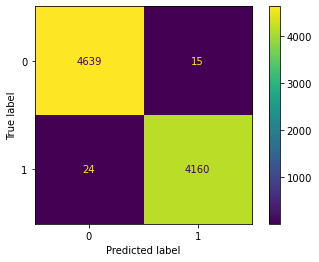

In [71]:
print('\nAccuracy for test set based on Decision Tree Classifier model: {:.3f}'.format(dt_acc))
print('\nRecall score for test set based on Decision Tree Classifier model: {:.3f}'.format(dt_recall))
print('\nPrecision score for test set based on Decision Tree Classifier model: {:.3f}'.format(dt_pre))
print('\nF1 score for test set based on Decision Tree Classifier model: {:.3f}'.format(dt_f1))
print('\nFigure 14. Decision Tree Classifier - Confusion matrix for test set')
dt_disp.plot()
plt.show()


Looking at Figure 14, we can summarize:  

+ Our model predicted that 4661/8838 articles are fake news when there were actually 4654/8838 articles with fake news.  

+ Our model has an accuracy of 8797/8838 or 99.536%

#### 4.3.3 Compare supervised machine learning models

In [72]:
# create unsupervised dataframe to compare NMF and Kmeans model on test data
super_models = {'Model': ["Random Forest", "Logistic Regression", "Decision Tree"],
        'Accuracy': [rf_acc, log_acc, dt_acc],
        'Recall': [rf_recall, log_recall, dt_recall],
        'Precision': [rf_pre, log_pre, dt_pre],
        'F1': [rf_f1, log_f1, dt_f1],}
super_data = pd.DataFrame(super_models)
super_data = super_data.sort_values(by='Accuracy', ascending = False, ignore_index=True)
print("Compare supervised machine learning models on test data: ")
display(super_data)


Compare supervised machine learning models on test data: 


,Model,Accuracy,Recall,Precision,F1
0,Decision Tree,0.995587,0.994264,0.996407,0.995334
1,Logistic Regression,0.988798,0.992113,0.984349,0.988216
2,Random Forest,0.955193,0.923279,0.980955,0.951244


We observe that Decision Tree Classifier is the best supervised model with highest accuracy, recall, precison and f1 score.

### 4.4 Compare Unsupervised  and Supervised Machine Learning models

In [74]:
# create unsupervised dataframe to compare NMF and Kmeans model on test data
models = {'Model': ["NMF", "Kmeans", "Random Forest", "Logistic Regression", "Decision Tree"],
        'Accuracy': [accuracy_test, accuracy_test_kmeans, rf_acc, log_acc, dt_acc]}

data = pd.DataFrame(models)
data = data.sort_values(by='Accuracy', ascending = False, ignore_index=True)
print("Compare unsupervised and supervised machine learning models on test data: ")
display(data)


Compare unsupervised and supervised machine learning models on test data: 


,Model,Accuracy
0,Decision Tree,0.995587
1,Logistic Regression,0.988798
2,Random Forest,0.955193
3,Kmeans,0.913329
4,NMF,0.836615


Looking at table above, we can see that, in overall, supervised machine learning algorithms show a better performance compare with unsupervised machine learning algorithms and in this project, Decision Tree is the best model.

### 4.5 Use supervised models to predict new text data without label

In [76]:
news = str(input())


"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam.  In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI.  The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI.  But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election.  The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI.  The FBI’s leadership is being warned that the entire lef

In [77]:
# create dataframe of new data
news_dic = {"text": news}
new_data = pd.DataFrame([news_dic])


In [78]:
# clean news data
clean_text(new_data, "text")

# view new data after cleaning
new_data["text"][0]

'daniel greenfield shillman journalism fellow freedom center new york writer focusing radical islam final stretch election hillary rodham clinton gone war fbi word unprecedented thrown around often election ought retired still unprecedented nominee major political party go war fbi thats exactly hillary people done coma patient waking watching hour cnn hospital bed would assume fbi director james comey hillary opponent election fbi attack everyone obama cnn hillary people circulated letter attacking comey currently medium hit piece lambasting targeting trump wouldnt surprising clinton ally start running attack ad fbi fbi leadership warned entire leftwing establishment form lynch mob continue going hillary fbi credibility attacked medium democrat preemptively head result investigation clinton foundation hillary clinton covert struggle fbi agent obamas doj people gone explosively public new york time compared comey j edgar hoover bizarre headline james comey role recall hoover fbi fairly 

#### Use supervised machine learning to predict new unlabeled data

In [79]:
def new_pipeline_func(vectorizer, clf):
    pipeline = Pipeline(
        [
            ('vect', vectorizer),
            ('clf', clf)
        ]
    )

    # fit and predict test set
    pipeline.fit(train.text, train.label)
    y_pred = pipeline.predict(new_data.text)
    return y_pred

In [80]:
# random forest
rf_pred = new_pipeline_func(vectorizer, rf_best)

# logistic regression
log_pred = new_pipeline_func(vectorizer, LogisticRegression())

# decison tree
dt_pred = new_pipeline_func(vectorizer, DecisionTreeClassifier())

In [81]:
print("Random Forest Prediction: ", rf_pred[0])
print("Logistic Regression Prediction: ", log_pred[0])
print("Decision Tree Prediction: ", dt_pred[0])

Random Forest Prediction:  fake
Logistic Regression Prediction:  fake
Decision Tree Prediction:  fake


## Step 5: Summary

In this project, there are 5 parts:  

(1) Gather data, determine the method of data collection and provenance of the data.     
(2) Identify Unsupervised Learning Problem.  
(3) EDA - Inspect, Visualize, and Clean the data.   
(4) Building and training models:  
+ NMF  
+ Kmeans  
+ Random Forest  
+ Logistic Regression  
+ Decision Tree
        
(5) Summary     

The goal of this project is to detect fake news, to help news readers to identify bias and misinformation in news articles in a quick and reliable fashion. By comparing two unsupervised and three supervised learning algorithms, we can conclude that, in this project:

* in overall, supervised learning algorithms have better performance compare with unsupervised learning algorithms.   
* Decision Tree Classifier is the best model with the highest accuracy score on the test set 99.5%.      
* Logistic Regression model is the second best model with the accuracy score on the test set 98.9%.     

* Compare between two unsupervised learning models, Kmeans performance is better than NMF with the accuracy score on the test set 91.3% and 83.7% for NMF.  
    
Finally, I used supervised learning models, included Random Forest, Logistic Regression and Decision Tree to predict new unlabeled data and all three models predict new data is fake.  

Because of the limitation of data and the running time was too costly, the models just were trained on limited data and limited approach. I think there are many other ways can improve this kind of project such as: building more unsupervised models by tuning hyperparameters to get optimal results, or use other type of Word Embeddings such as: Tokenization, Bag-of-Words or Count Vectorizer. Besides that, I could not test models on more new data because of the costly running time.
